{{< pagebreak >}}

In [1]:
import numpy as np
import pandas as pd 
import pandas_datareader as pdr 
import matplotlib.pyplot as plt
import yfinance as yf 
import seaborn as sns
import statsmodels as stm
import scipy.optimize as sco

import warnings
warnings.filterwarnings("ignore")
np.set_printoptions(suppress=True, precision=8)
%config InlineBackend.figure_format = 'retina'

## Asset Classes

### Functions

In [2]:
def sharpe(rp):
    rp_rf = rp.sub(df['RF'])
    return (rp_rf.mean() / rp_rf.std())    

In [3]:
def beta(rp):
    rp_rf = rp.sub(df['RF'])
    rm_rf = df['Mkt-RF']
    beta = (rp_rf.cov(rm_rf)) / rm_rf.var()
    return beta

In [4]:
def treynor(rp):
    rp_rf = rp.sub(df['RF'])
    rm_rf = df['Mkt-RF']
    treynor = rp_rf.mean() / beta(rp)
    return treynor


In [5]:
def alpha(rp):
    alpha = (rp - (df['RF'] + beta(rp)*(df['Mkt-RF']))).mean()
    return alpha

### Calculations

#### Data
- **Duration:** 1928 to 2023
- **Sources:** Annual returns for the asset classes sourced from Prof. Aswath Damodaran.

In [6]:
ff = (
    pdr.DataReader(
        name='F-F_Research_Data_Factors',
        data_source='famafrench',
        start='1900'
    )
    [1]
    .div(100)
)

In [7]:
df = pd.read_csv('histretSP.csv')
df.set_index('Year', inplace=True)
RF = pd.DataFrame(ff['RF'])

Mkt_RF = pd.DataFrame(ff['Mkt-RF'])
RF.index = RF.index.year
Mkt_RF.index = Mkt_RF.index.year

df['RF'] = RF['RF'].loc[1928:2023]
df['Mkt-RF'] = Mkt_RF['Mkt-RF'].loc[1928:2023]

{{< pagebreak >}}
### Stats

In [8]:
asset_stats = df[['S&P 500','T-Bill','T-Bond','Baa Bond','Real Estate','Gold']].agg(['mean','std', sharpe, beta, treynor, alpha])

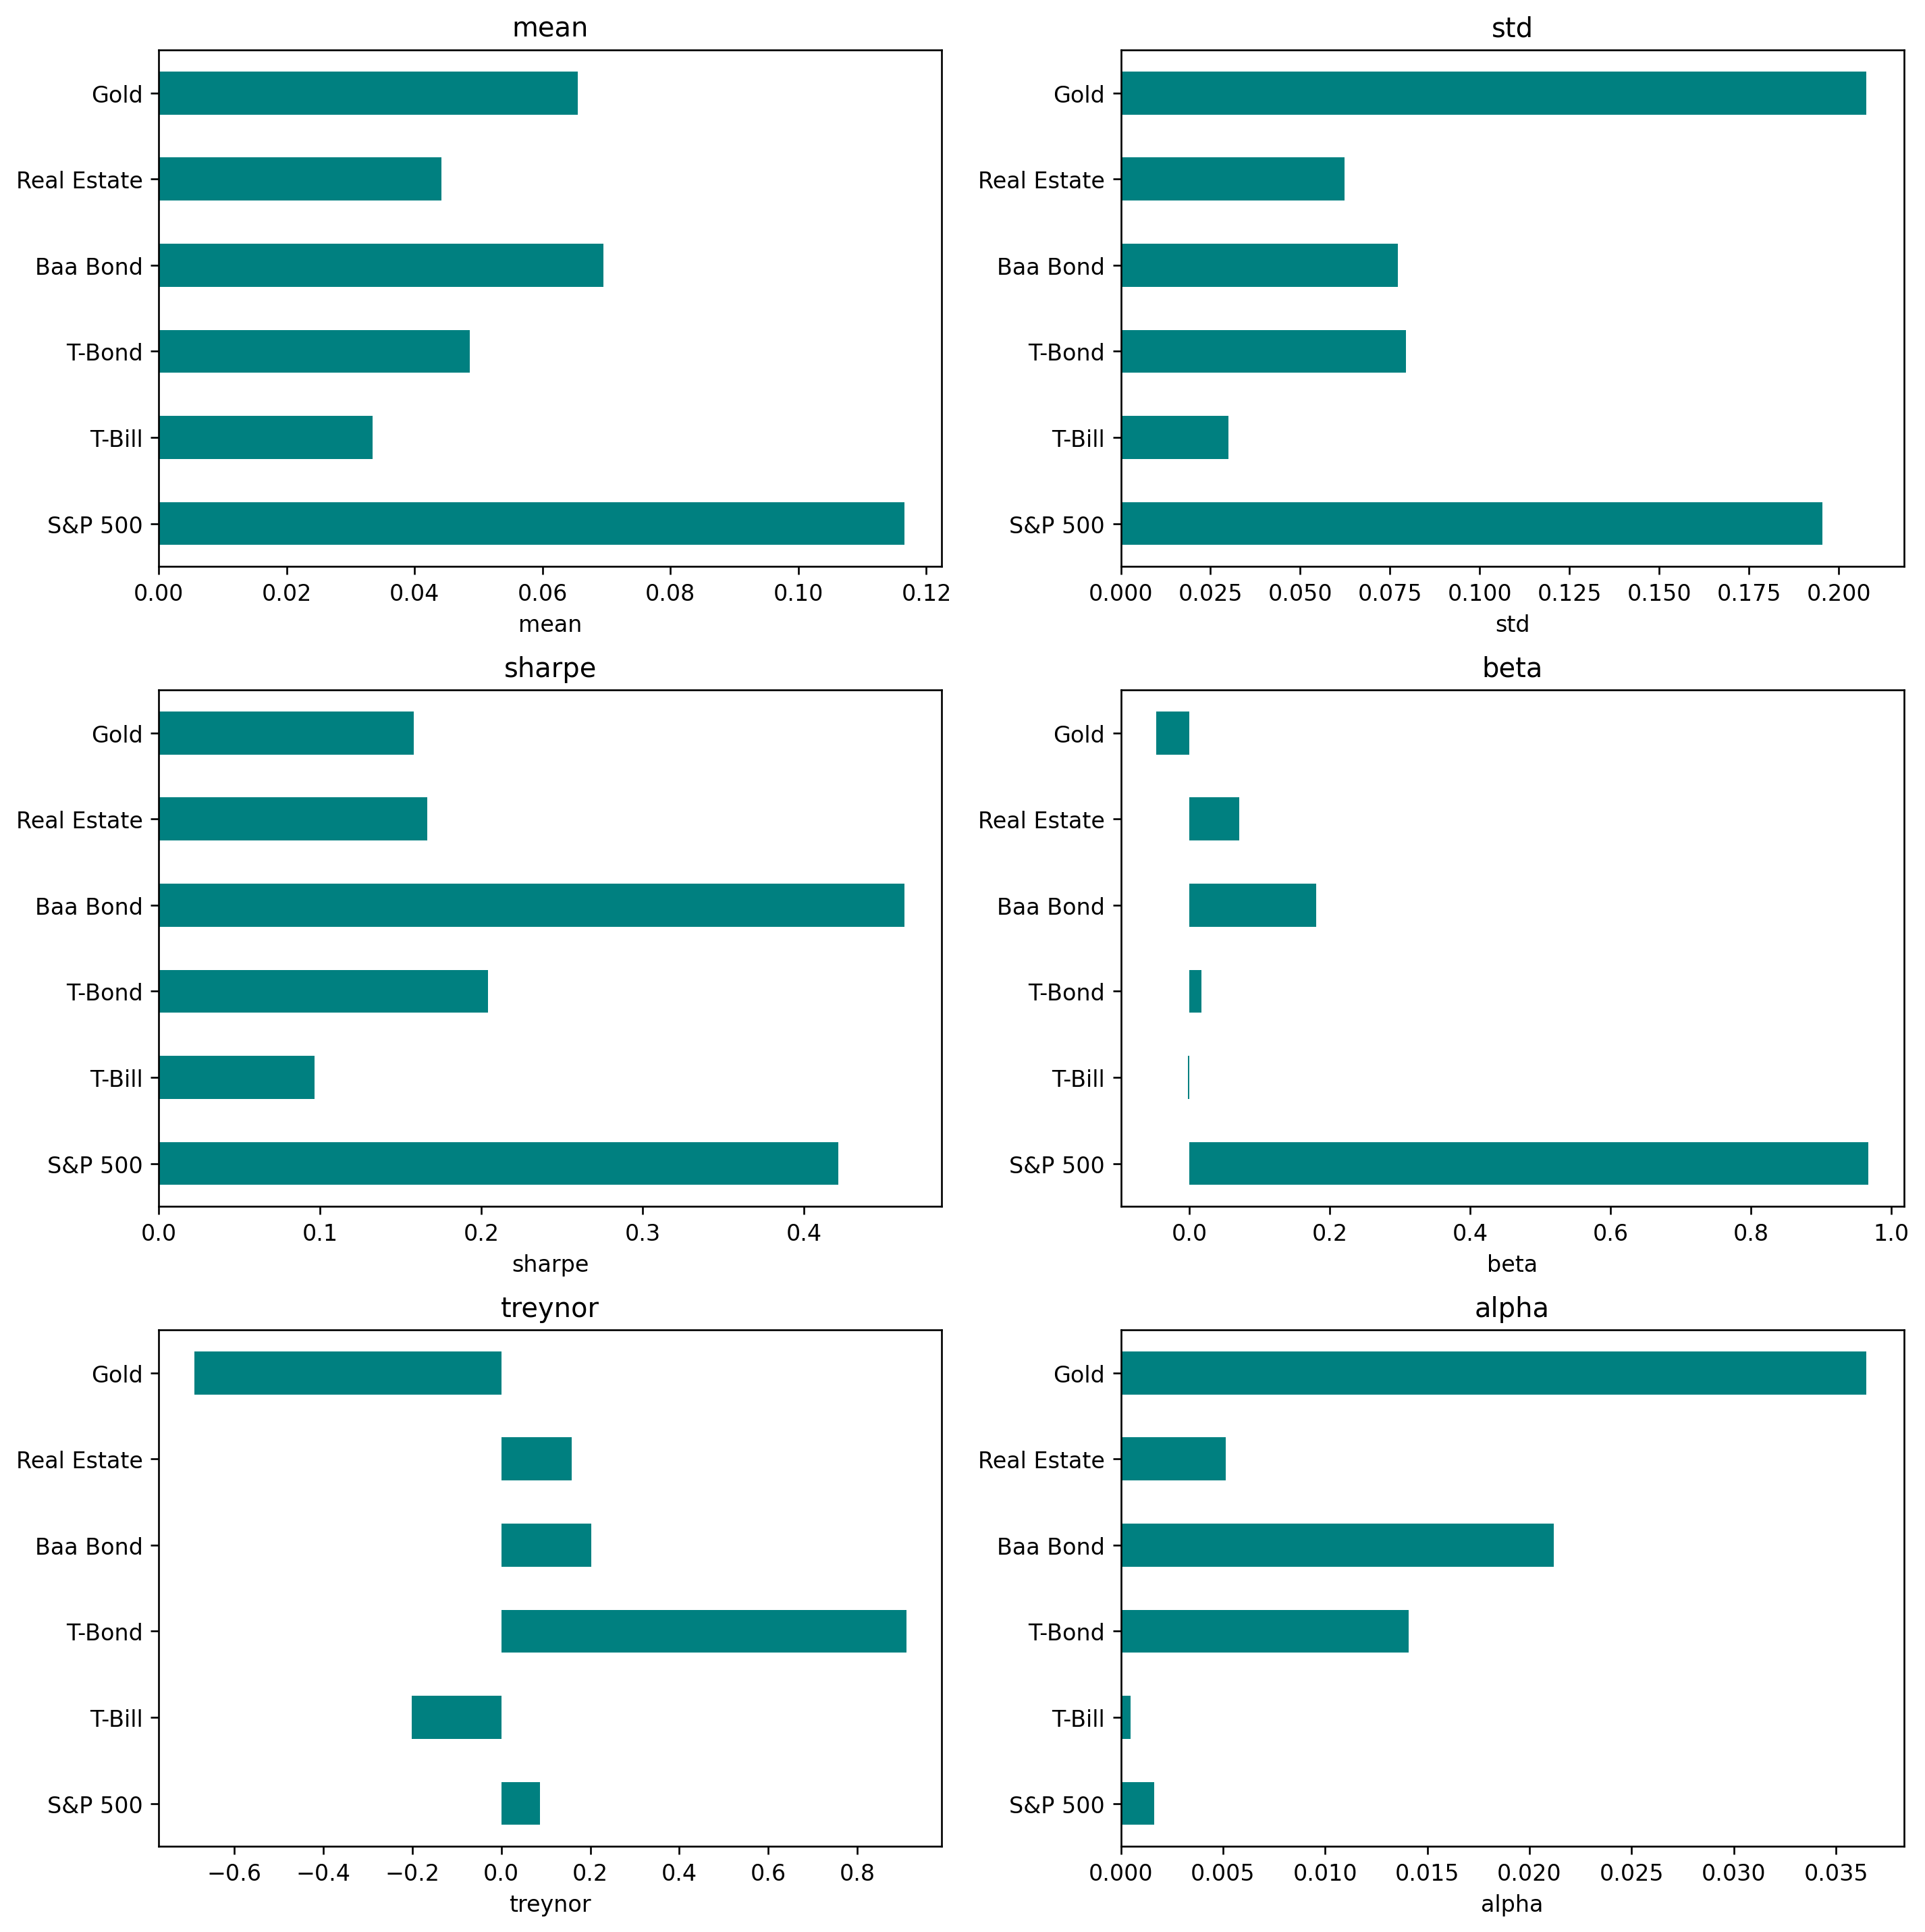

In [9]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 12), dpi=120) 
axs = axs.flatten()

for ax, metric in zip(axs, asset_stats.index):
    asset_stats.loc[metric].plot(kind='barh', ax=ax, title=metric, color='teal')
    ax.set_xlabel(metric)

plt.tight_layout()
plt.show()

{{< pagebreak >}}

In [10]:
asset_stats

,S&P 500,T-Bill,T-Bond,Baa Bond,Real Estate,Gold
mean,0.116578,0.033385,0.048587,0.069537,0.044181,0.065542
std,0.195508,0.030075,0.079517,0.077123,0.062416,0.207722
sharpe,0.421299,0.096586,0.203908,0.462150,0.166283,0.157832
beta,0.966823,-0.001721,0.017084,0.180885,0.070781,-0.047091
treynor,0.086407,-0.201101,0.910112,0.201776,0.157428,-0.690216
alpha,0.001650,0.000492,0.014101,0.021177,0.005148,0.036492


### Insights from key stats

- The S&P 500 and Gold stand out with high mean returns, indicating their potential for significant growth. However, they also come with substantial risk as evidenced by their high standard deviations. Investors in these assets can expect considerable price fluctuations and should have a higher risk tolerance.

- T-Bills, with the lowest mean return and standard deviation, serve as the conservative choice for risk-averse investors, providing stability at the cost of growth potential.

- Baa Bonds and Real Estate present a balance, offering moderate returns. Their risk profiles are higher than T-Bills but lower than the S&P 500 and Gold. The Sharpe ratios for Baa Bonds and Real Estate are relatively high, indicating favorable returns for the level of risk taken compared to other assets.

- Cumulative returns further highlight the long-term growth potential of Gold and the S&P 500, despite their volatility.

- In summary, there's a clear trade-off where higher returns are generally associated with higher risk. Conservative assets like T-Bills provide - lower returns with minimal risk, whereas growth-oriented assets like the S&P 500 and Gold come with higher risk and volatility. Baa Bonds and Real Estate fall in the middle, offering a compromise between risk and return.

{{< pagebreak >}}
### Capital Market Line

- The S&P 500 has the highest mean annual return and the highest volatility, placing it at the upper end of the spectrum. This implies that there is more risk involved even while there is a chance for higher returns.

- The lowest mean annual return and volatility are found in T-Bills, which are short-term government securities. This is consistent with their low-risk, low-return investment nature.

- T-Bonds and real estate seem to provide a midway ground, offering reasonable mean annual returns at risk-adjusted levels. Remarkably, for a given level of returns, T-Bonds are less volatile than real estate.

- Although gold has underperformed stocks in terms of returns, it has an intriguing profile in that it has less volatility and lower returns than the S&P 500, indicating that it could be a more reliable store of value in the long run.


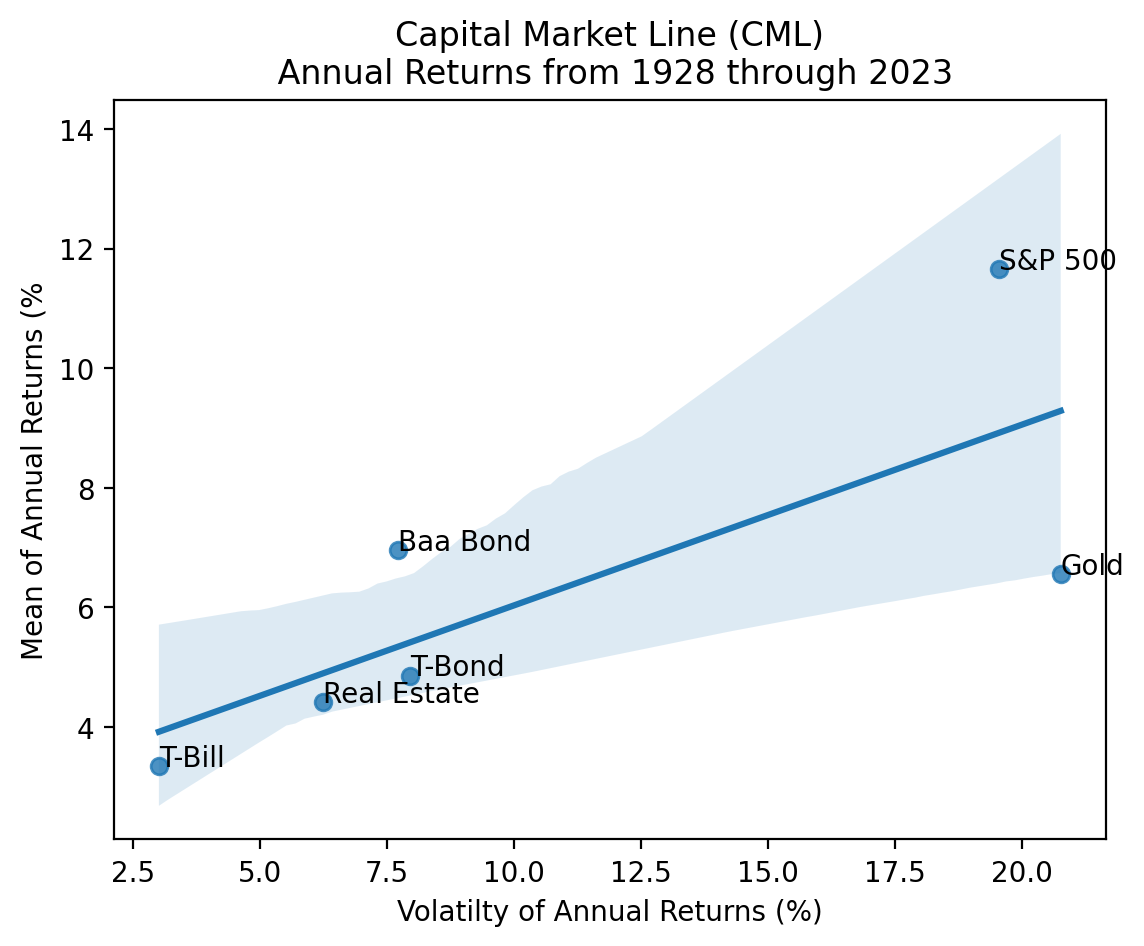

In [11]:
CML = (
    df.iloc[:,:6]
    .mul(100)
    .agg(['mean', 'std'])
    .transpose()
)

sns.regplot(
    data=CML,
    y='mean',
    x='std'
)

for t, (x, y) in CML[['std', 'mean']].iterrows():
    plt.annotate(text=t, xy=(x, y))

plt.xlabel('Volatilty of Annual Returns (%)')
plt.ylabel('Mean of Annual Returns (%')
plt.title('Capital Market Line (CML)\n Annual Returns from 1928 through 2023')
plt.show()

### Correlation Matrix

- The fixed-income instruments, Baa Bonds and T-Bonds, exhibit the largest positive correlation (0.65), indicating a tendency towards similar movement patterns and potential similarities in risk factors or economic drivers.

- With regard to all other assets, gold exhibits a low to slightly negative correlation; the S&P 500 exhibits the highest negative correlation, at -0.075. This suggests that gold frequently acts differently from other asset classes, which could make it useful in a multi-asset portfolio as a hedge or diversifier.

- The correlation between the S&P 500 and T-Bills is negative (-0.031), suggesting that the performance of stock and short-term government securities move independently of each other and may react to market conditions in different ways.

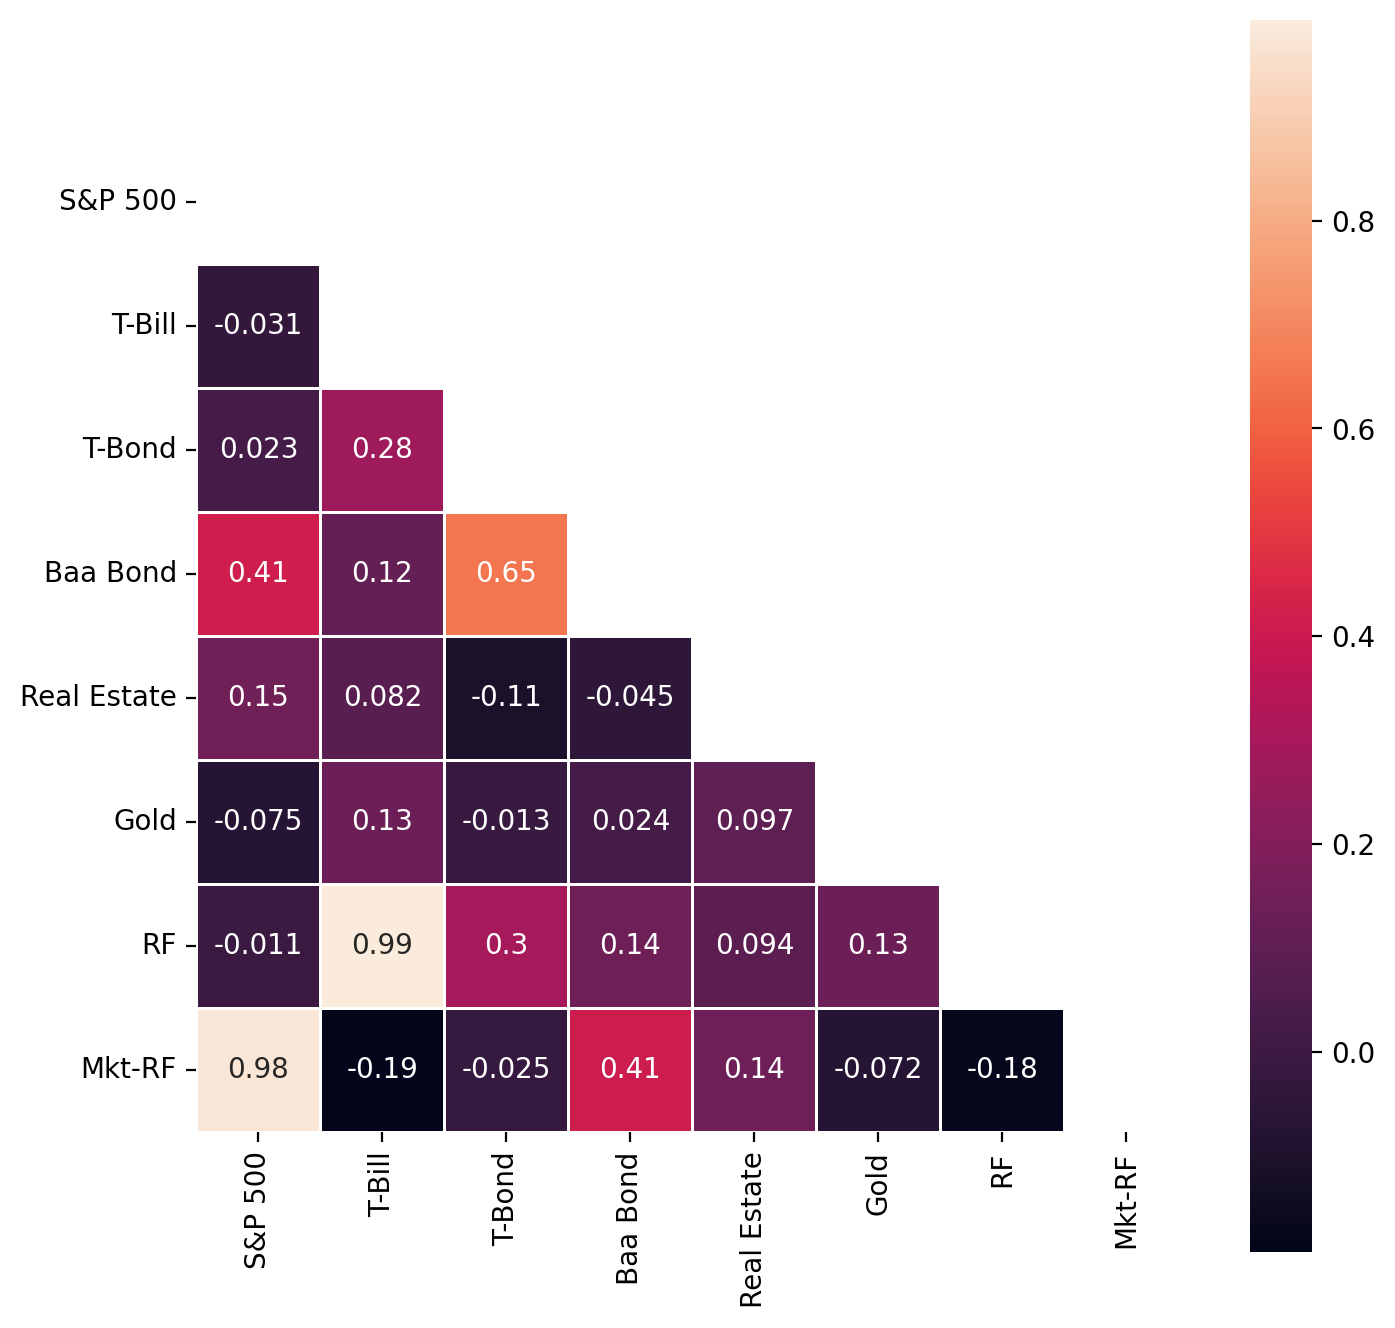

In [12]:
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(8,8))
sns.heatmap(corr, mask=mask,  square=True, linewidths=.5, annot=True)
plt.show()

In [13]:
portfolios_stats_now = pd.DataFrame()
portfolios_stats_then = pd.DataFrame()
portfolios_stats_alltime = pd.DataFrame()

{{< pagebreak >}}
## Portfolios :

#### Portfolios Preview
- **All Equities:**
  - Composition: 100% S&P 500
  - Duration: 1928 to 2023

- **60/40 Portfolio:**
  - 60% S&P 500 (equities)
  - 40% Intermediate Treasury Bonds

- **Harry Browne’s Permanent Portfolio:**
  - 25% S&P 500
  - 25% Long-term Treasury Bonds
  - 25% Treasury Bills (cash)
  - 25% Gold

- **Ray Dalio’s All Seasons Portfolio:**
  - 30% S&P 500
  - 40% Long-term Treasury Bonds
  - 15% Intermediate Treasury Bonds
  - 7.5% Commodities
  - 7.5% Gold


### All Equity Portfolio

Pros:

- High growth potential: Fully invested in equities, maximizing exposure to potential market gains.
- Simplicity: Easier to manage due to only one asset class.

Cons:

- High volatility: Entirely exposed to market swings, which can lead to significant fluctuations in value.
- No risk cushion: Lacks the stability that bonds or other asset classes provide during downturns.

Improvements:

- Introduction of diversifiers: Incorporating assets like bonds or commodities could reduce volatility and improve the risk-return profile.
  
- Tactical asset allocation: Adjusting equity exposure based on market conditions could help manage risks more effectively.

Mean-Variance Efficiency and Risk-Return Trade-Off:

- Initially: The high standard deviation relative to the mean return indicates a potentially less efficient mean-variance position, reflecting the high risk associated with an all-equity approach.

- Current Insights: The high beta confirms significant market sensitivity, which can impact the portfolio negatively during market downturns.

In [14]:
df['All Equity'] = df['S&P 500']
portfolios_stats_alltime['All Equity'] =  df['All Equity'].agg(['mean','std', sharpe, beta, treynor, alpha])

### Traditional 60-40 portfolio

Pros:

- Balanced exposure: Combines growth potential of equities with the stability of bonds.
- Risk management: Bonds provide a buffer against equity market volatility.

Cons:

- Moderate growth limitation: The substantial bond allocation may limit the portfolio's growth potential during bullish equity markets.

Improvements:

- Dynamic rebalancing: Implementing a strategy to adjust the equity-bond ratio based on market predictions could enhance returns.
  
- Yield-focused bond investments: Incorporating higher-yielding bonds could improve overall portfolio yield without significantly increasing risk.

Mean-Variance Efficiency and Risk-Return Trade-Off:

- Initially: Shows a more favorable balance between risk and return as indicated by a higher Sharpe ratio compared to the All Equity Portfolio.
  
- Current Insights: Lower beta than the All Equity Portfolio suggests better risk management, but still considerable sensitivity to market movements.

In [15]:
p2_equity_weight = 0.6
p2_bond_weight = 0.4

df['Sixty Forty'] = p2_equity_weight * df['S&P 500'] + p2_bond_weight * df['T-Bond']
portfolios_stats_alltime['Sixty Forty'] = df['Sixty Forty'].agg(['mean','std', sharpe, beta, treynor, alpha])

{{< pagebreak >}}
### Harry Browne's Portfolio

Pros:

- Diversification: Balances stocks, bonds, cash, and gold, reducing exposure to any single asset's downturn.
- Stability: Incorporation of cash and bonds provides stability during market volatility.
- Inflation protection: Gold helps protect against inflation.

Cons:

- Growth limitation: Equal allocation may limit growth potential from equities during bull markets.
- Rebalancing need due to drift: Regular rebalancing required to maintain the 25% allocation across different asset classes.

Improvements : 

- Increase equities: Slightly higher allocation to equities might boost returns while maintaining a balanced risk profile.
- Dynamic rebalancing: Implement strategies based on market conditions rather than fixed percentages.


Mean-Variance Efficiency and Risk-Return Trade-Off:

- Initially: The portfolio displayed a relatively high Sharpe ratio, suggesting effective management of the risk-return trade-off and a position close to mean-variance efficiency at its inception.

- Currently: There is a noticeable decrease in the Sharpe ratio, indicating a possible reduction in mean-variance efficiency. This suggests that the risk-return balance may have shifted, potentially due to changes in market conditions affecting its diverse asset classes.

Additional Insights on Risk and Return:

- The mix of stocks, bonds, cash, and gold is designed to provide stability. The current lower beta suggests a continued low market risk, which aligns with the portfolio's conservative approach, although this may also limit potential higher returns during bullish market phases.

In [16]:
p3_equity_weight = 0.25
p3_tbond_weight = 0.25
p3_tbill_weight = 0.25
p3_gold_weight = 0.25

# Earlier period
df['Harry_Brown_Then'] = p3_equity_weight * df['S&P 500'].loc[1928:1980] + p3_tbond_weight * df['T-Bond'].loc[1928:1980] + p3_tbill_weight * df['T-Bill'].loc[1928:1980] + p3_gold_weight * df['Gold'].loc[1928:1980]
portfolios_stats_then['Harry_Brown_Then'] = df['Harry_Brown_Then'].agg(['mean','std', sharpe, beta, treynor, alpha])

# Later period
df['Harry_Brown_Now'] = p3_equity_weight * df['S&P 500'].loc[1980:2023] + p3_tbond_weight * df['T-Bond'].loc[1980:2023] + p3_tbill_weight * df['T-Bill'].loc[1980:2023] + p3_gold_weight * df['Gold'].loc[1980:2023]
portfolios_stats_now['Harry_Brown_Now'] = df['Harry_Brown_Now'].agg(['mean','std', sharpe, beta, treynor, alpha])

# All time
df['Harry_Brown_All_Time'] = p3_equity_weight * df['S&P 500'] + p3_tbond_weight * df['T-Bond'] + p3_tbill_weight * df['T-Bill'] + p3_gold_weight * df['Gold']
portfolios_stats_alltime['Harry_Brown_AT'] = df['Harry_Brown_Now'].agg(['mean','std', sharpe, beta, treynor, alpha])

### Ray Dalio's All Weather Portfolio

Pros:

- Risk management: Higher allocation to bonds provides a cushion against equity market drops.
- Inflation hedge: Commodities and gold offer protection against inflation.
- Diversified bond exposure: Mix of long-term and intermediate bonds smoothens interest rate risks.

Cons:

- Complexity: More complex to manage due to the variety of asset classes.
- Potential underperformance: Higher bond allocation might lead to underperformance in strong equity markets.

Improvements:

- Reassess bond allocation: Decreasing bond exposure and increasing allocation to equities or alternative investments could enhance returns, especially in lower interest rate environments.
  
- Enhanced diversification: Consider introducing more asset classes like real estate or private equity for further diversification.

Mean-Variance Efficiency and Risk-Return Trade-Off:

- Initially: This portfolio also started with a high Sharpe ratio, indicating a good balance in risk-return management, aligning closely with mean-variance efficiency principles.
  
- Currently: The slight decline in the Sharpe ratio, coupled with an increase in standard deviation, points towards a potential decrease in efficiency. This might reflect a greater sensitivity to market volatility than initially, affecting the overall risk-return dynamics.

Additional Insights on Risk and Return:

- With a substantial allocation to bonds and diversification into commodities, this portfolio aims for steady performance across various market conditions. However, the current higher beta and increased volatility indicate a possibly higher market sensitivity, which could influence its risk-return profile.

In [17]:
p4_equity_weight = 0.3
p4_tbond_weight = 0.4
p4_ibond_weight = 0.15
p4_gold_weight = 0.075
p4_commodities_weight = 0.075

# Earlier period
df['Ray_Dalio'] = p4_equity_weight * df['S&P 500'].loc[1928:2014] + p4_tbond_weight * df['T-Bond'].loc[1928:2014] + p4_ibond_weight * df['T-Bond'].loc[1928:2014] + p4_gold_weight * df['Gold'].loc[1928:2014] + p4_commodities_weight * df['Gold'].loc[1928:2014]
portfolios_stats_then['Ray_Dalio'] = df['Ray_Dalio'].agg(['mean','std', sharpe, beta, treynor, alpha])

# Later period
df['Ray_Dalio'] = p4_equity_weight * df['S&P 500'].loc[2014:2023] + p4_tbond_weight * df['T-Bond'].loc[2014:2023] + p4_ibond_weight * df['T-Bond'].loc[2014:2023] + p4_gold_weight * df['Gold'].loc[2014:2023] + p4_commodities_weight * df['Gold'].loc[2014:2023]
portfolios_stats_now['Ray_Dalio'] = df['Ray_Dalio'].agg(['mean','std', sharpe, beta, treynor, alpha])

# All time
df['Ray_Dalio'] = p4_equity_weight * df['S&P 500'].loc[1928:2028] + p4_tbond_weight * df['T-Bond'].loc[1928:2028] + p4_ibond_weight * df['T-Bond'].loc[1928:2028] + p4_gold_weight * df['Gold'].loc[1928:2028] + p4_commodities_weight * df['Gold'].loc[1928:2028]
portfolios_stats_alltime['Ray_Dalio'] = df['Ray_Dalio'].agg(['mean','std', sharpe, beta, treynor, alpha])

{{< pagebreak >}}
### Diamondman Morgan's Portfolio

Pros:

- Diversified approach: Includes multiple asset classes (equities, bonds, gold), providing a comprehensive balance of growth, income, and protection.
  
- Inflation protection: Gold and Baa Bonds add layers of risk mitigation against inflation and market downturns.

Cons:

- Complexity: Managing multiple asset types requires more sophisticated strategies and monitoring.
  
- Potential for underperformance: High diversification might dilute potential high returns from equities during strong market rallies.

Improvements:

- Reassess asset allocation: Fine-tuning the percentages based on current market conditions could enhance performance.
  
- Enhanced yield strategies: Could incorporate strategies like dividend growth equities or high-yield bonds to improve income without excessively increasing risk.

Mean-Variance Efficiency and Risk-Return Trade-Off:

- Initially: Exhibits the highest Sharpe ratio among the three, suggesting a strong initial balance between risk and return.
  
- Current Insights: The lowest beta of the three portfolios indicates less sensitivity to market movements, aligning well with its risk management strategy.

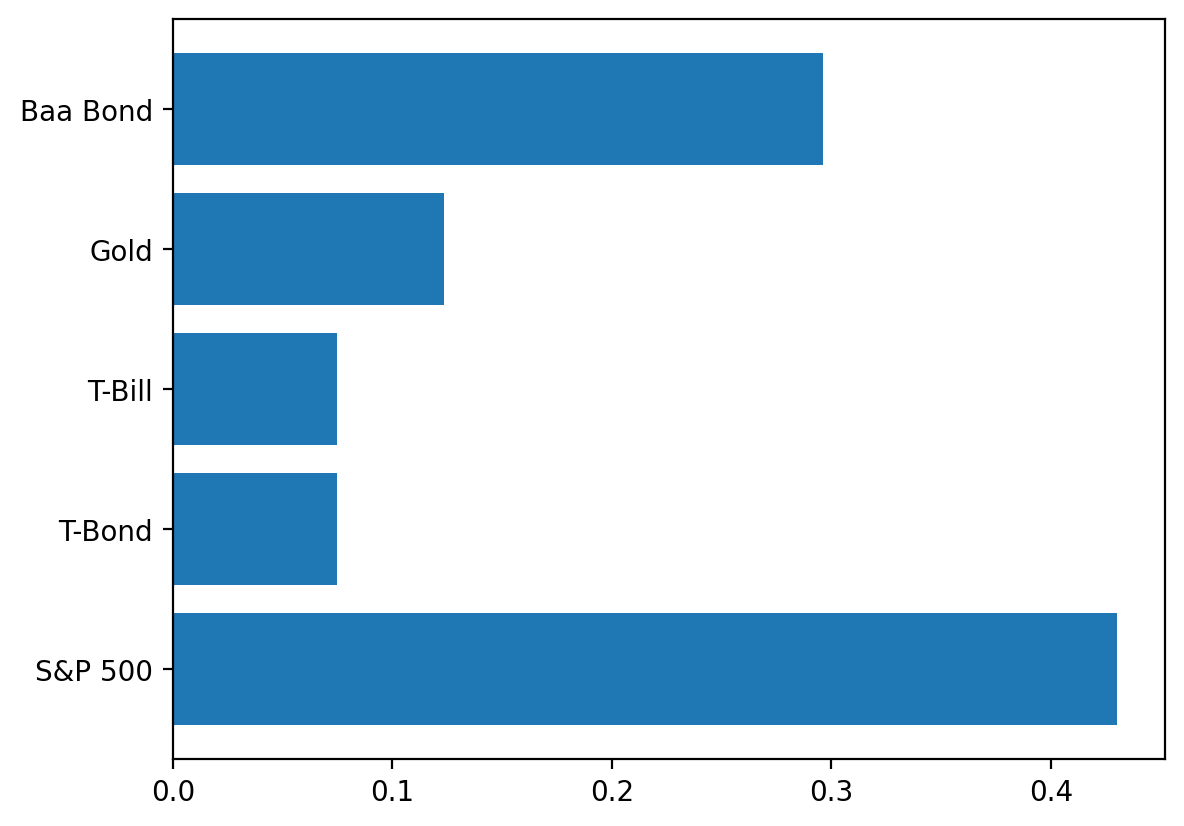

In [18]:

df_po = df[['S&P 500', 'T-Bond','T-Bill','Gold', 'Baa Bond']]

def calc_neg_sharpe(x, r, tgt):
    rp = r.dot(x)
    excess_rp = rp - tgt
    sharpe_ratio = excess_rp.mean() / excess_rp.std()
    return -sharpe_ratio

x0 = np.ones(df_po.shape[1]) / df_po.shape[1]
bounds = [(0.075, 0.7) for _ in df_po.columns]
bounds

constraints = [
    {'type': 'eq', 'fun': lambda x: x.sum() - 1},  # Ensure total weight is 1
    {'type': 'ineq', 'fun': lambda x: df_po.dot(x).mean()- 0.085},  # Ensure minimum return of 8.5%
    {'type': 'ineq', 'fun': lambda x: (df_po.dot(x) - df['RF']).mean() / (df_po.dot(x) - df['RF']).std()}  # Minimum Sharpe ratio
]

result = sco.minimize(
    fun=calc_neg_sharpe,
    x0=x0,
    args=(df_po, df['RF']),
    bounds=bounds,
    constraints=constraints
)

optimized_weights = result.x
portfolios_stats_alltime['Diamondman Morgan'] = (df_po.dot(optimized_weights).agg(['mean','std', sharpe, beta, treynor, alpha]))

plt.barh(
    y=df_po.columns,
    width=result['x']
)

portfolio_5_weights = result['x']

returns = df_po * portfolio_5_weights

{{< pagebreak >}}
## The Diamondman Morgan Portfolio

#### Our portfolio consists of a mix of S&P 500 equities, T-Bonds, T-Bills, Gold, and Baa Bonds, which together aim to balance growth with risk management effectively.

- Broad Diversification: Combining stocks, bonds, and gold spreads risk and enhances stability across various market conditions.
- Growth Potential: A significant portion in 'S&P 500' equities drives growth, supported by the income and safety from 'T-Bonds', 'T-Bills', and 'Baa Bonds'.
- Inflation Hedge: Gold provides protection against inflation, adding a layer of security to the portfolio.

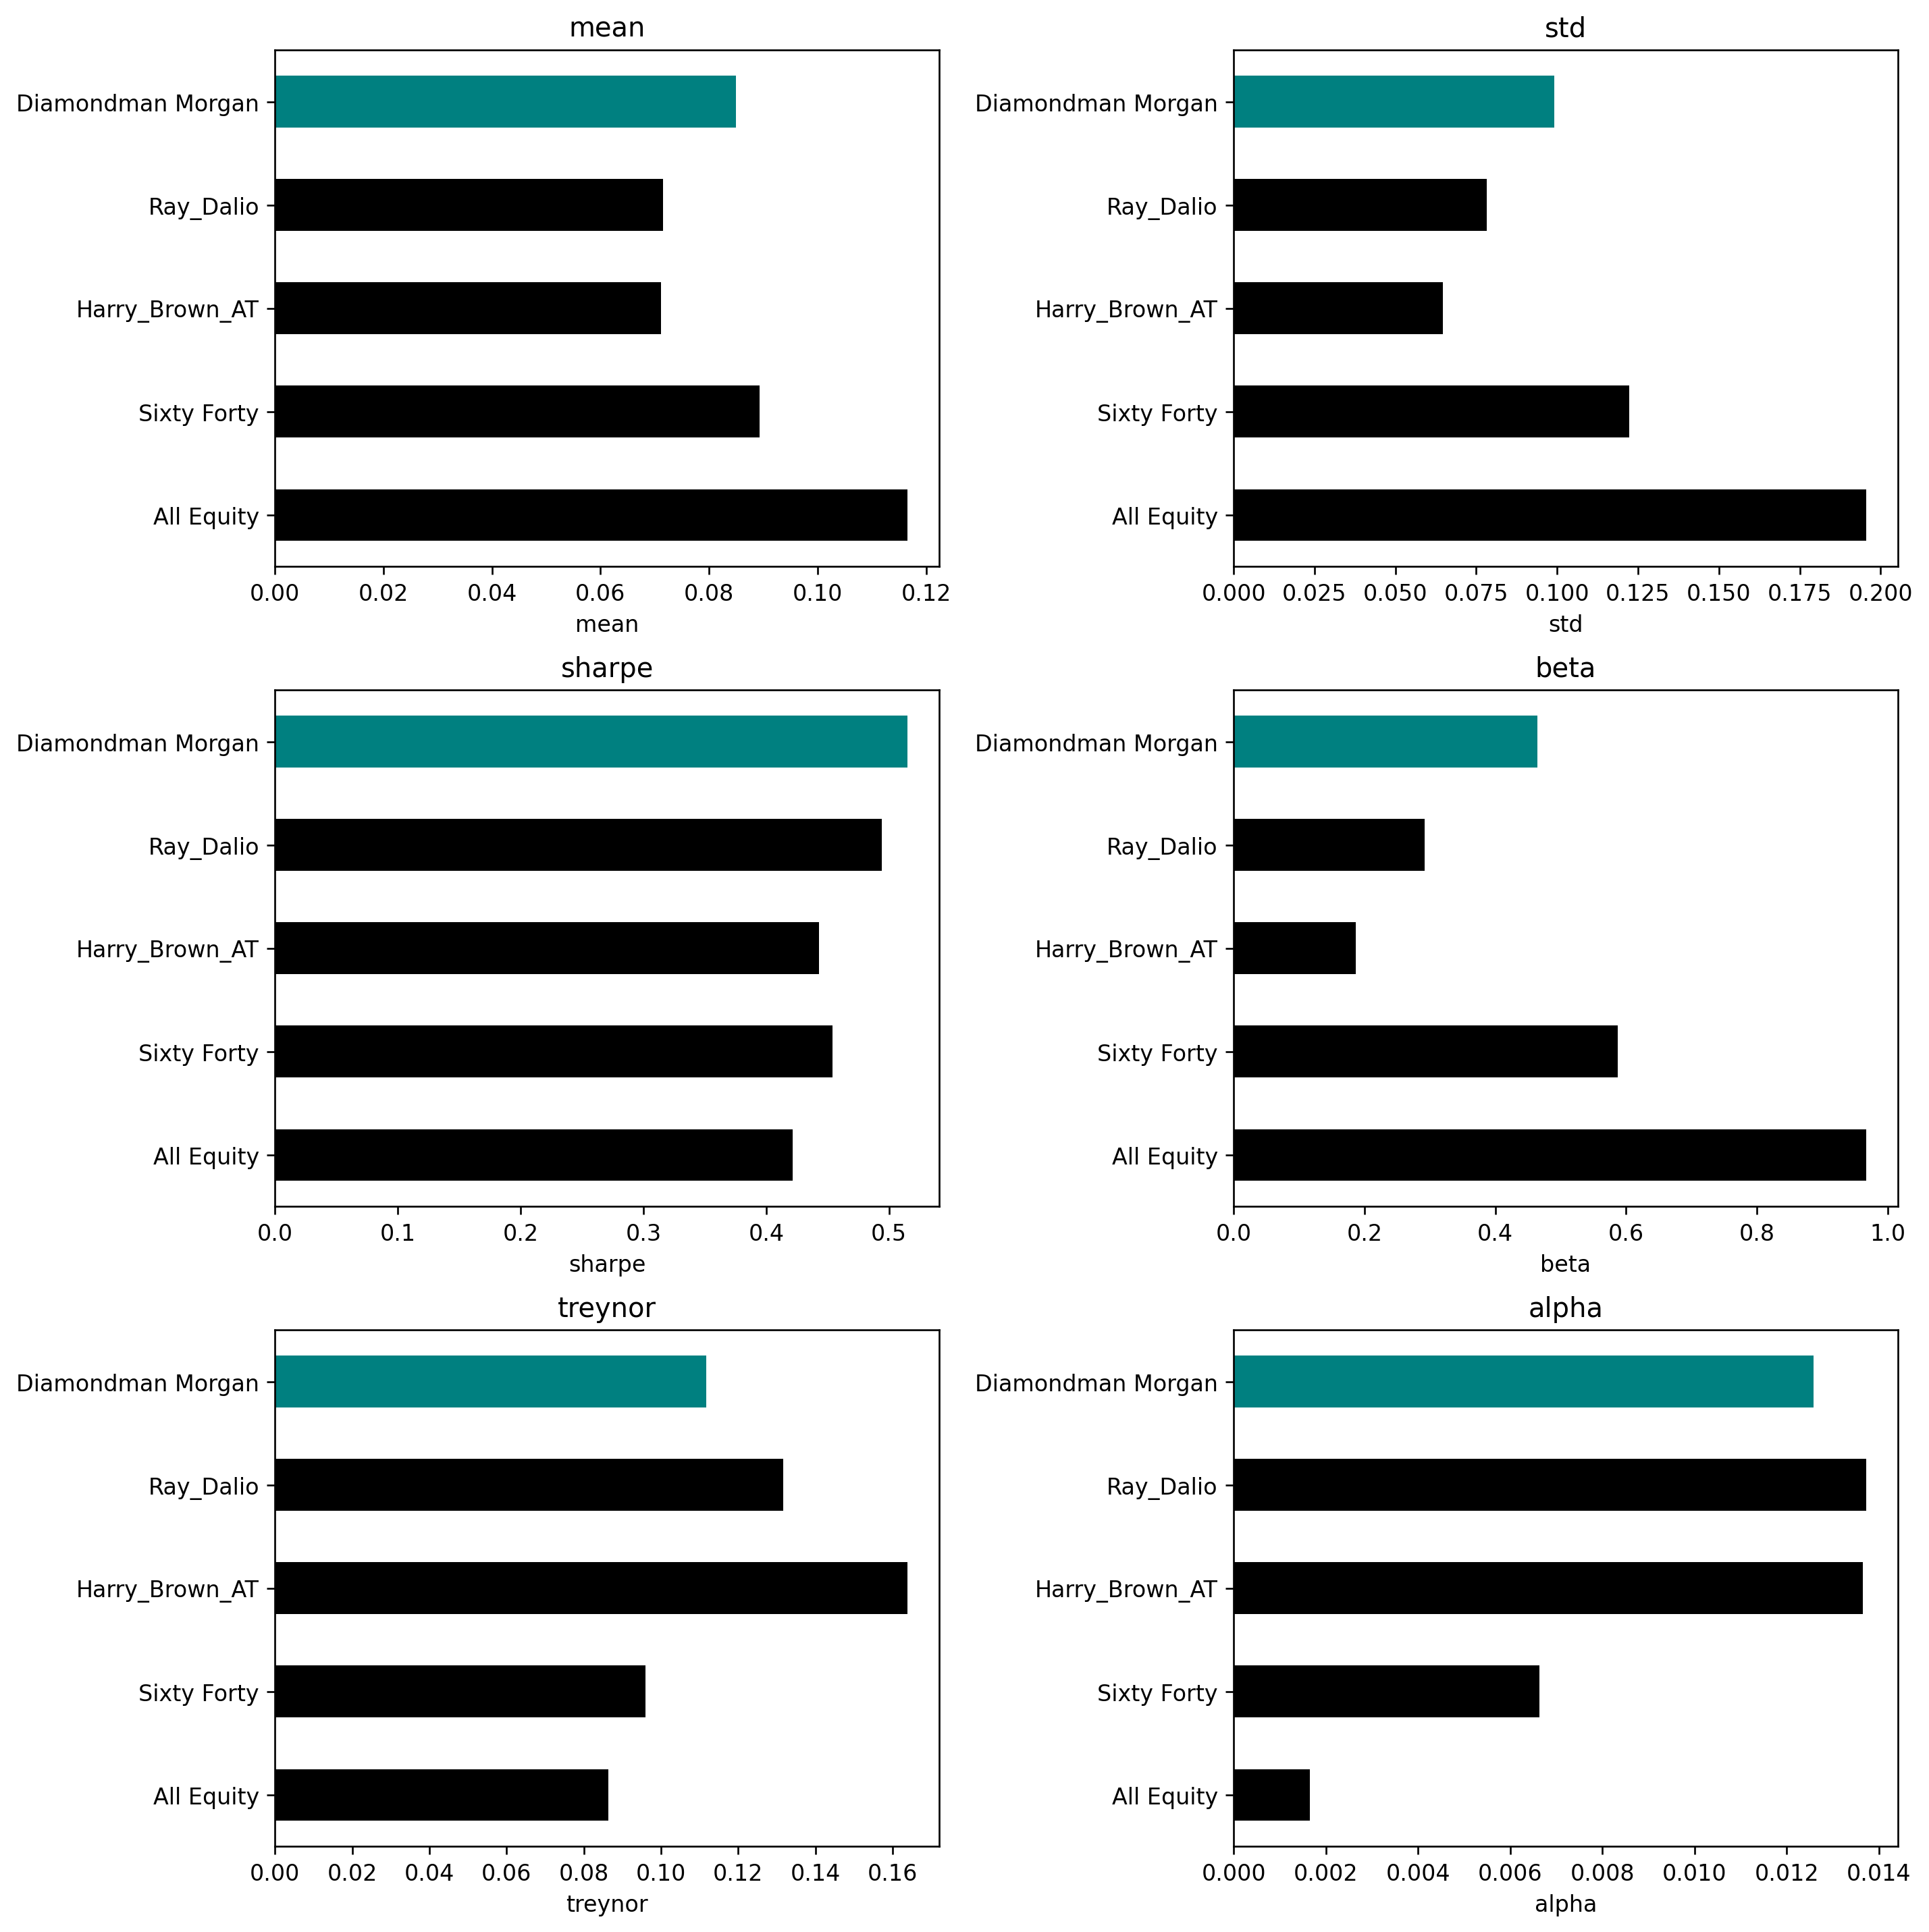

In [19]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 12), dpi=120)
axs = axs.flatten()

for ax, metric in zip(axs, portfolios_stats_alltime.index):
    colors = ['k' if column != 'Diamondman Morgan' else 'teal' for column in portfolios_stats_alltime.columns]
    portfolios_stats_alltime.loc[metric].plot(kind='barh', ax=ax, title=metric, color=colors)
    ax.set_xlabel(metric)

plt.tight_layout()
plt.show()

{{< pagebreak >}}
### Portfolio Drawdowns

- All Equity: Shows larger drawdowns, implying higher risk during market downturns.
- Sixty Forty: Experiences moderate drawdowns, reflecting a balance between stocks and bonds.
- Harry Browne All Time: Drawdowns are in line with Sixty Forty, indicating risk control.
- Ray Dalio: Has drawdowns that are generally less than All Equity, suggesting a diversified risk approach.
- Diamondman Morgan: Displays smaller drawdowns, pointing to more consistent performance over time.

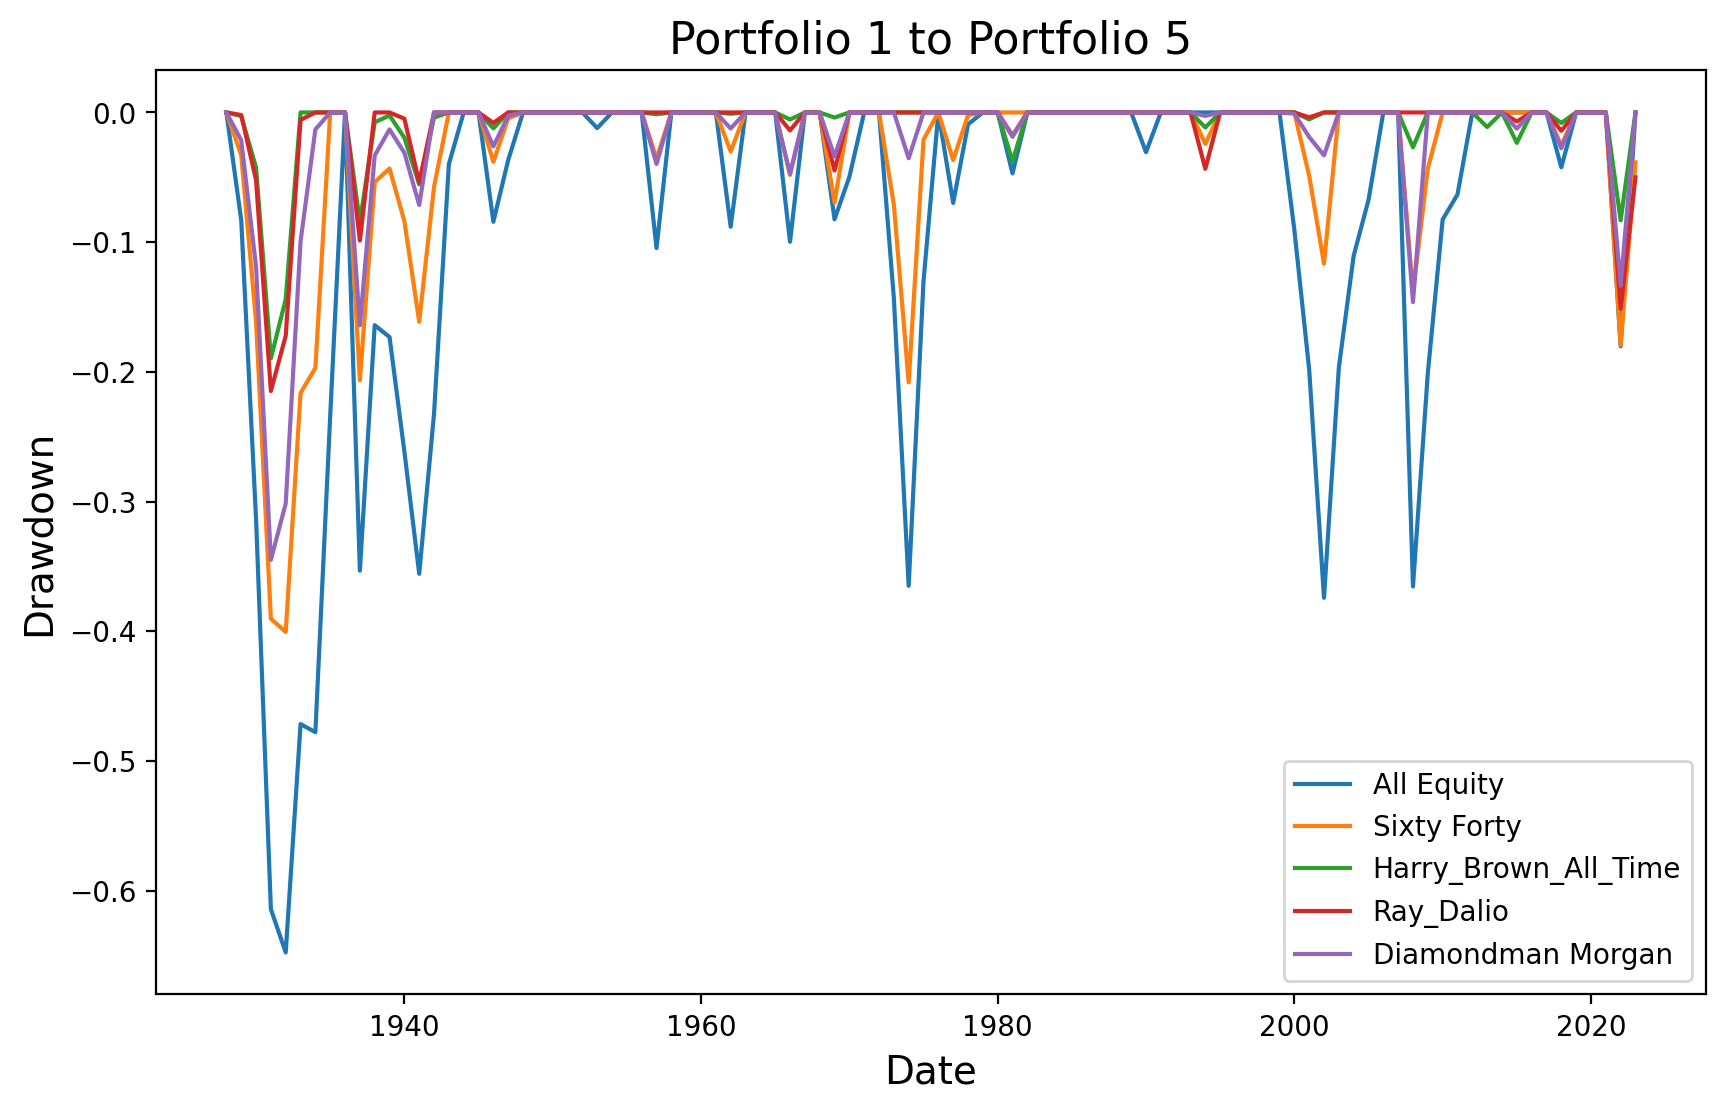

In [20]:
df['Diamondman Morgan'] = df_po.dot(result['x'])

df_dd = df[['All Equity', 'Sixty Forty','Harry_Brown_All_Time','Ray_Dalio', 'Diamondman Morgan']]

import matplotlib.pyplot as plt
cols = df_dd.columns[0:]
fig, ax = plt.subplots(figsize=(10, 6))
for col in cols:
    cumulative_product = df_dd[col].add(1).cumprod()
    drawdown = (cumulative_product / cumulative_product.cummax()) - 1
    ax.plot(drawdown.index, drawdown.values, label=col)


ax.set_title("Portfolio 1 to Portfolio 5", fontsize=16)
ax.set_xlabel("Date", fontsize=14)
ax.set_ylabel("Drawdown", fontsize=14)


ax.legend()

plt.show()

### Capital Market Line

- Diamondman Morgan Is closer to the CML, suggesting it achieves returns near the optimal market portfolio for its risk.

- Harry Browne All Time & Ray Dalio: These portfolios are positioned below the Capital Market Line, suggesting they may be providing lower returns for their level of risk compared to the optimal market portfolio.

- Sixty Forty & All Equity: These portfolios appear closer to or on the Capital Market Line, indicating they are more aligned with the optimal risk-return balance offered by the market portfolio.

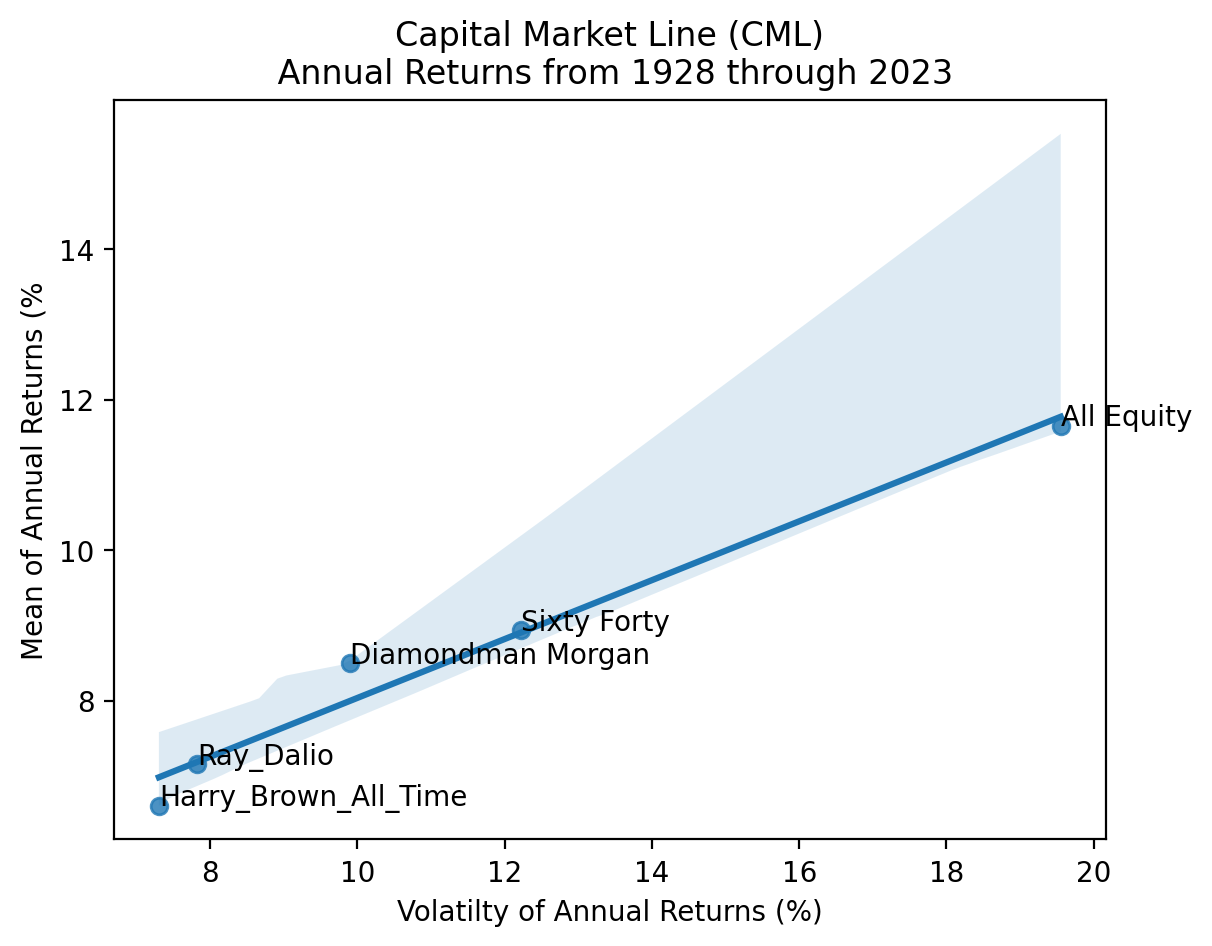

In [21]:
CML = (
    df_dd.iloc[:,:6]
    .mul(100)
    .agg(['mean', 'std'])
    .transpose()
)

sns.regplot(
    data=CML,
    y='mean',
    x='std'
)

for t, (x, y) in CML[['std', 'mean']].iterrows():
    plt.annotate(text=t, xy=(x, y))

plt.xlabel('Volatilty of Annual Returns (%)')
plt.ylabel('Mean of Annual Returns (%')
plt.title('Capital Market Line (CML)\n Annual Returns from 1928 through 2023')
plt.show()

{{< pagebreak >}}
### Efficient Frontier

In [22]:
returns = df.iloc[:, :6]

In [23]:
tret = np.linspace(returns.mean().min(), returns.mean().max(), 25)
tret

array([0.0333847 , 0.0368511 , 0.04031751, 0.04378392, 0.04725033,
       0.05071674, 0.05418315, 0.05764955, 0.06111596, 0.06458237,
       0.06804878, 0.07151519, 0.07498159, 0.078448  , 0.08191441,
       0.08538082, 0.08884723, 0.09231364, 0.09578004, 0.09924645,
       0.10271286, 0.10617927, 0.10964568, 0.11311208, 0.11657849])

In [24]:
def port_vol(x, r):
    return  r.dot(x).std()

def port_mean(x, r):
    return r.dot(x).mean()

In [25]:
res_ef = []

for t in tret:
    _ = sco.minimize(
        fun=port_vol, 
        x0=np.ones(returns.shape[1]) / returns.shape[1],
        args=(returns),
        bounds=[(0, 1) for c in returns.columns],
        constraints=(
            {'type': 'eq', 'fun': lambda x: x.sum() - 1},
            {'type': 'eq', 'fun': lambda x: port_mean(x=x, r=returns) - t}

        )
    )
    res_ef.append(_)

res_ef[0]

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.03007519438747197
       x: [ 0.000e+00  1.000e+00  7.216e-16  0.000e+00  4.515e-08
            1.110e-16]
     nit: 2
     jac: [-5.993e-03  3.008e-02  2.188e-02  8.873e-03  5.114e-03
            2.782e-02]
    nfev: 14
    njev: 2

In [26]:
for r in res_ef:
    assert r['success']

ef = pd.DataFrame(
    {
        'tret': tret,
        'tvol': np.array([r['fun'] if r['success'] else np.nan for r in res_ef])
    }
)

returns.index = pd.to_datetime(returns.index, format='%Y')

S&P 500 19.550755529860943 11.657849316284231
T-Bill 3.007519551444416 3.3384696618560037
T-Bond 7.951693668014721 4.858678560684162
Baa Bond 7.712331367412982 6.953666857918128
Real Estate 6.241550494194507 4.4181455979654425
Gold 20.77224216620093 6.554177020740594


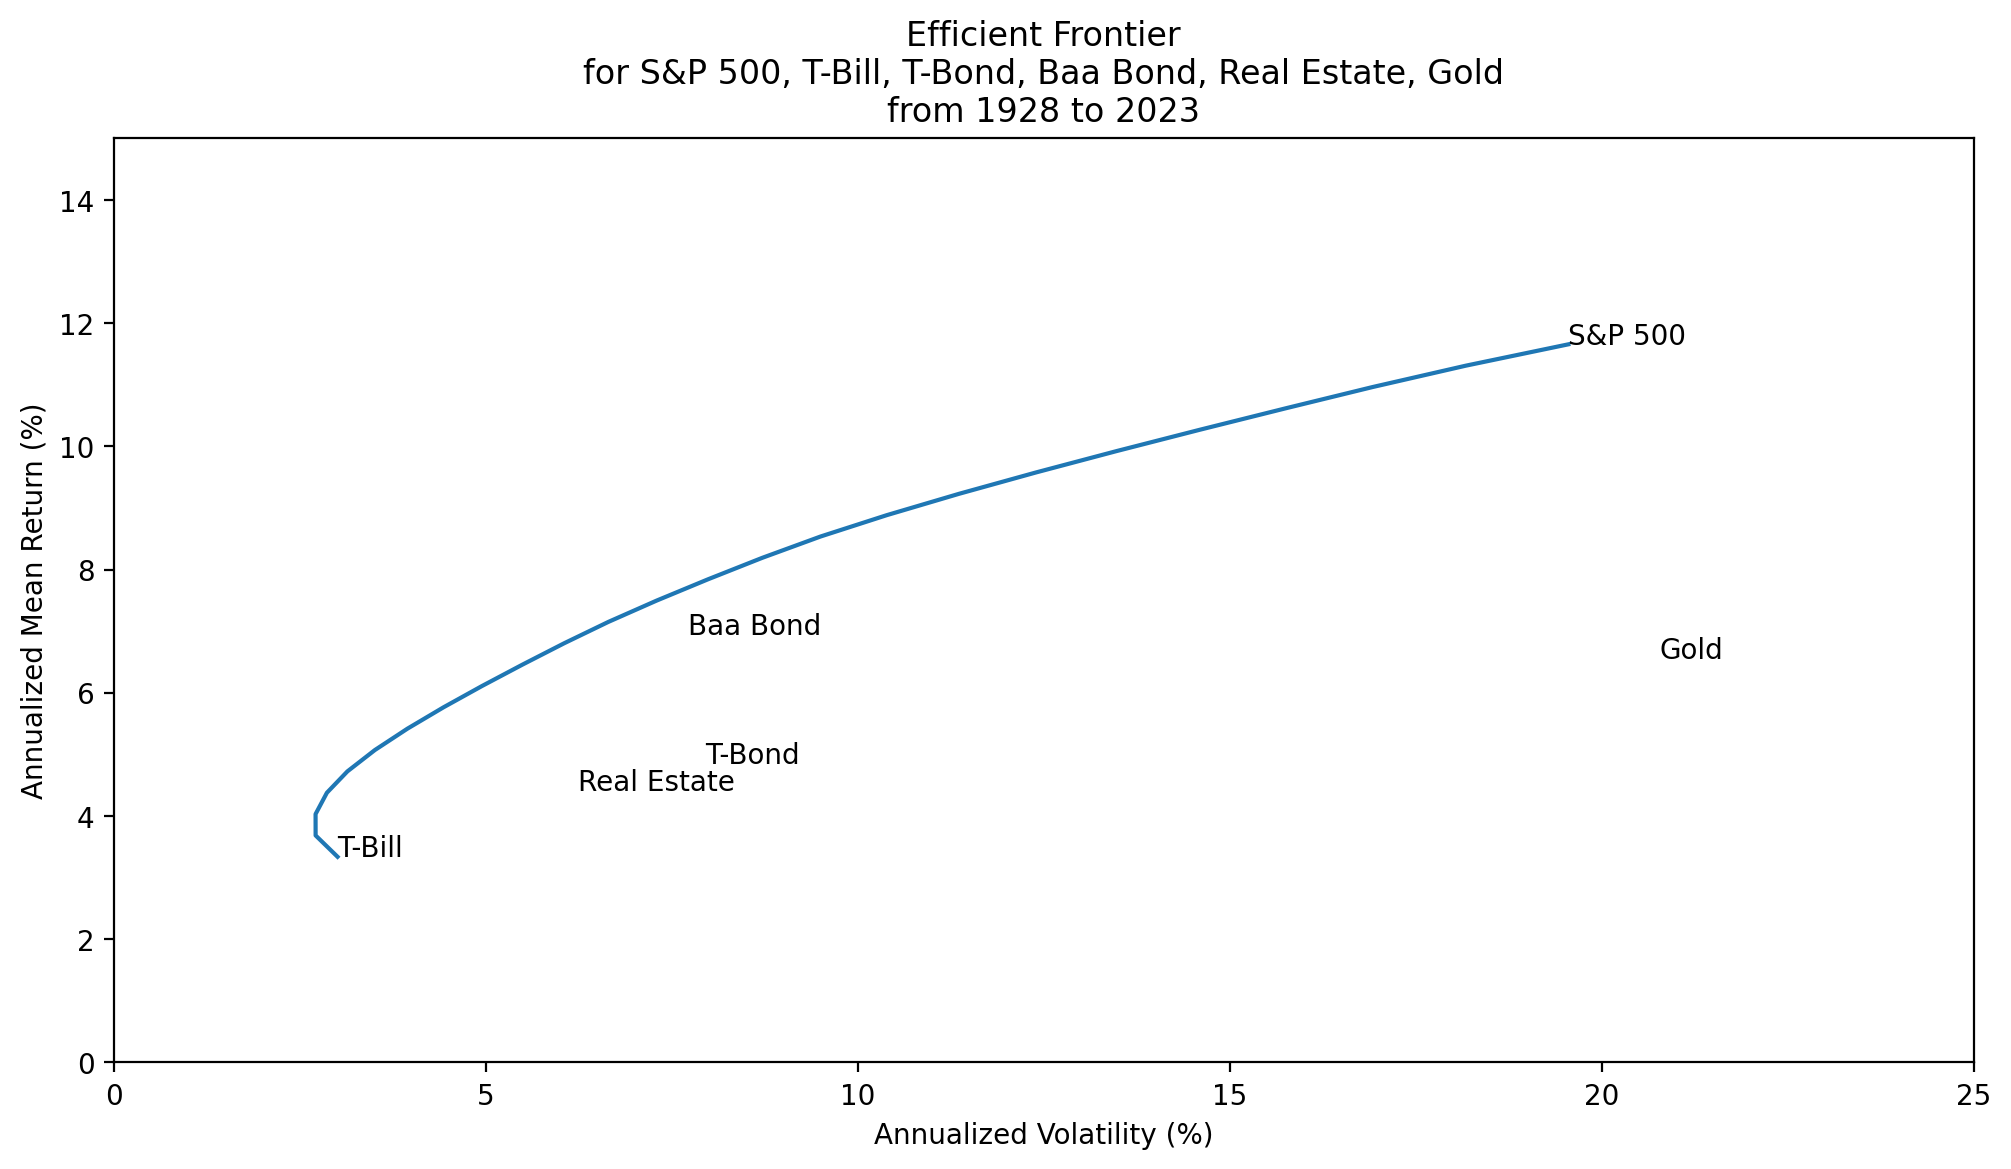

In [27]:
ef.mul(100).plot(x='tvol', y='tret', legend=False, figsize=(12,6))

plt.ylabel('Annualized Mean Return (%)')
plt.xlabel('Annualized Volatility (%)')
plt.title(
    f'Efficient Frontier' +
    f'\nfor {", ".join(returns.columns)}' +
    f'\nfrom {returns.index[0]:%Y} to {returns.index[-1]:%Y}'
)

plt.xlim(0, 25)
plt.ylim(0, 15)

for t, x, y in zip(
    returns.columns, 
    returns.std().mul(100),
    returns.mean().mul(100)
):
    print(t, x, y)
    plt.annotate(text=t, xy=(x, y))


plt.show()

{{< pagebreak >}}

In [28]:
tret = np.linspace(df_dd.mean().min(), df_dd.mean().max(), 25)
tret

array([0.06602294, 0.06812942, 0.0702359 , 0.07234238, 0.07444886,
       0.07655534, 0.07866183, 0.08076831, 0.08287479, 0.08498127,
       0.08708775, 0.08919423, 0.09130071, 0.0934072 , 0.09551368,
       0.09762016, 0.09972664, 0.10183312, 0.1039396 , 0.10604609,
       0.10815257, 0.11025905, 0.11236553, 0.11447201, 0.11657849])

In [29]:
def port_vol(x, r):
    return  r.dot(x).std()

def port_mean(x, r):
    return r.dot(x).mean()

In [30]:
res_ef = []

for t in tret:
    _ = sco.minimize(
        fun=port_vol,
        x0=np.ones(df_dd.shape[1]) / df_dd.shape[1],
        args=(df_dd),
        bounds=[(0, 1) for c in df_dd.columns],
        constraints=(
            {'type': 'eq', 'fun': lambda x: x.sum() - 1},
            {'type': 'eq', 'fun': lambda x: port_mean(x=x, r=df_dd) - t}

        )
    )
    res_ef.append(_)

res_ef[0]

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.07308135835110458
       x: [ 1.126e-17  0.000e+00  1.000e+00  1.950e-10  0.000e+00]
     nit: 3
     jac: [ 1.210e-01  8.235e-02  7.308e-02  7.061e-02  8.274e-02]
    nfev: 18
    njev: 3

In [31]:
for r in res_ef:
    assert r['success']

ef = pd.DataFrame(
    {
        'tret': tret,
        'tvol': np.array([r['fun'] if r['success'] else np.nan for r in res_ef])
    }
)

df_dd.index = pd.to_datetime(df_dd.index, format='%Y')

All Equity 19.550755529860943 11.657849316284231
Sixty Forty 12.224507662849804 8.938181014044204
Harry_Brown_All_Time 7.308135835158727 6.602293639891248
Ray_Dalio 7.831635440820032 7.152754556372648
Diamondman Morgan 9.90870597239746 8.49999999918175


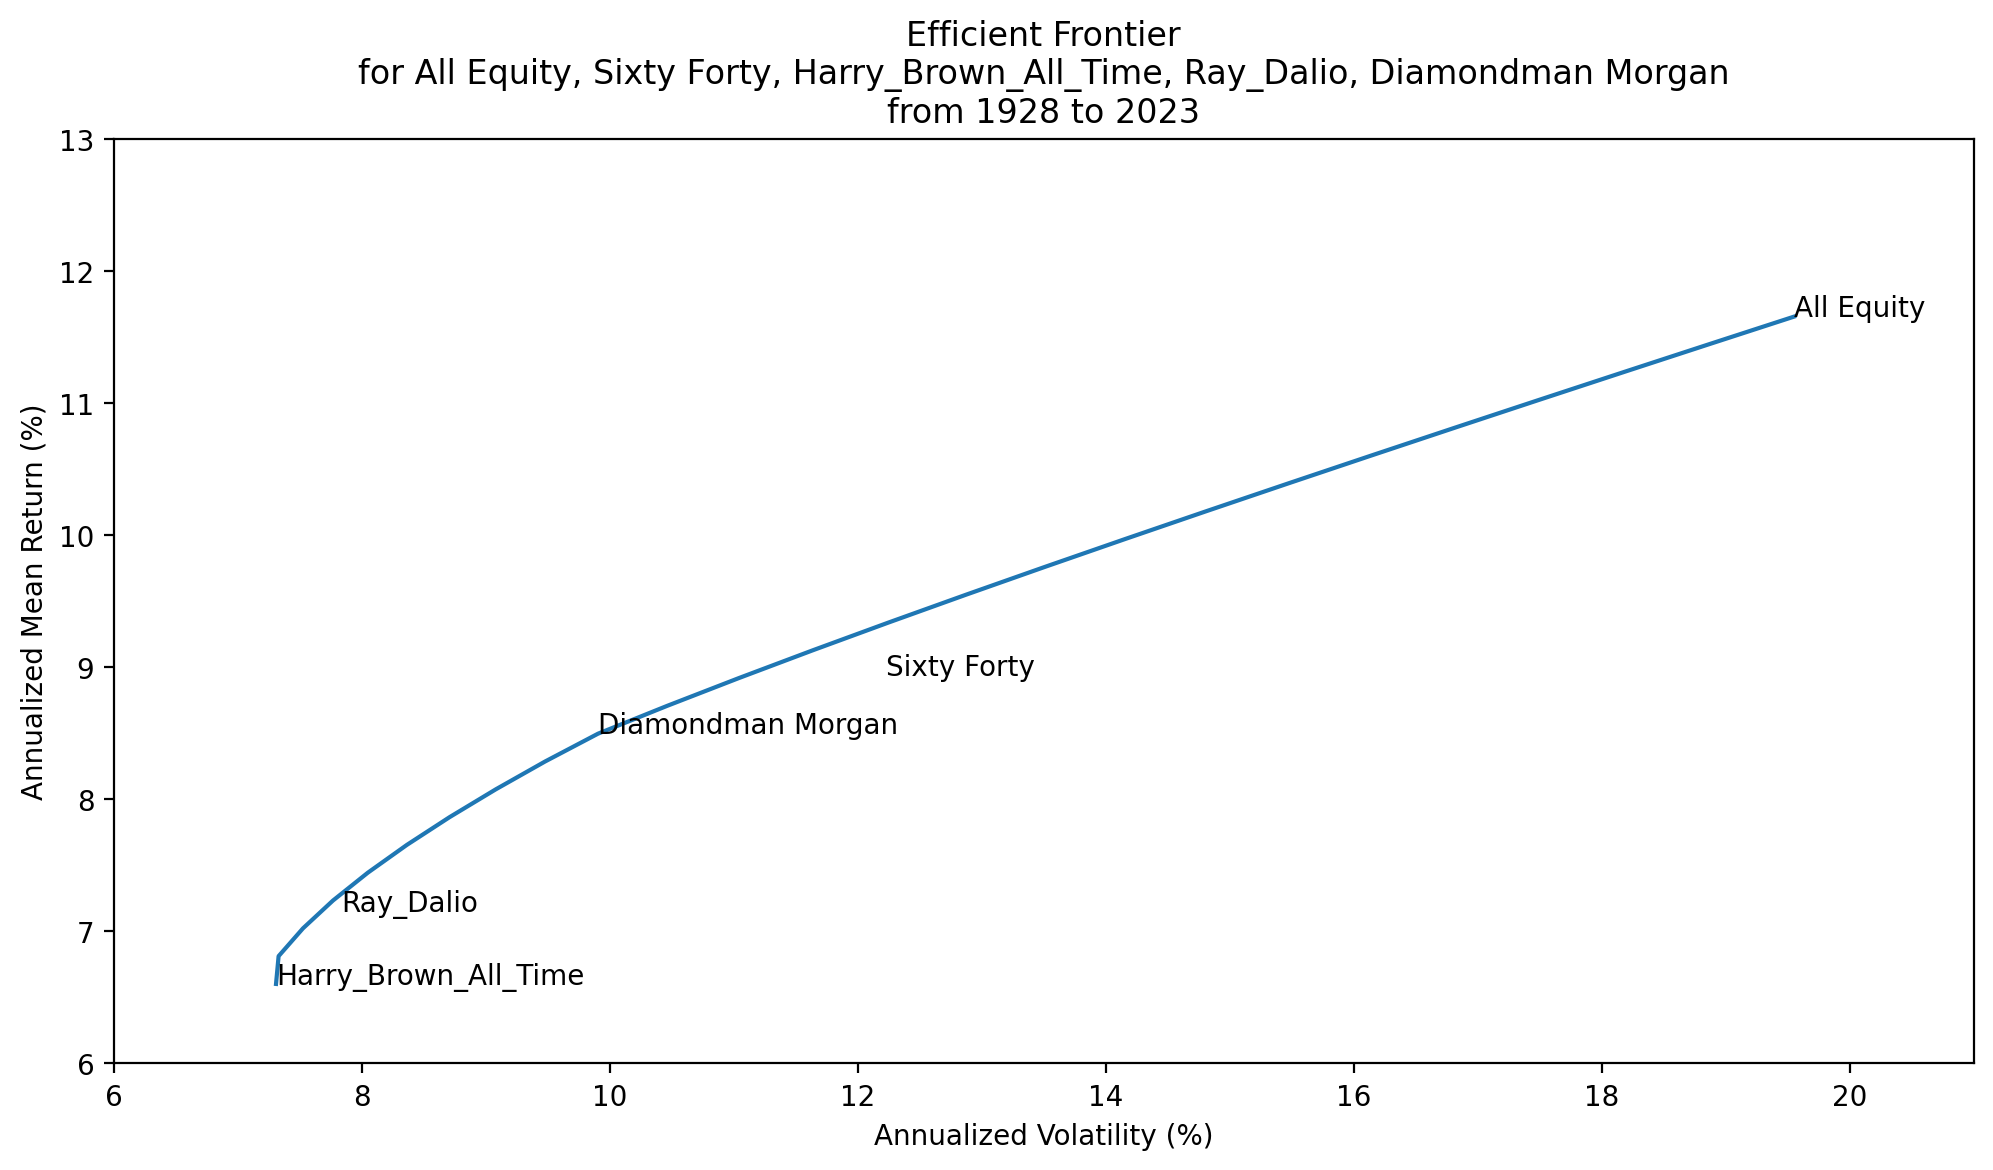

In [32]:
ef.mul(100).plot(x='tvol', y='tret', legend=False, figsize=(12,6))

plt.ylabel('Annualized Mean Return (%)')
plt.xlabel('Annualized Volatility (%)')
plt.title(
    f'Efficient Frontier' +
    f'\nfor {", ".join(df_dd.columns)}' +
    f'\nfrom {df_dd.index[0]:%Y} to {df_dd.index[-1]:%Y}'
)

plt.xlim(6,21)
plt.ylim(6,13)

for t, x, y in zip(
    df_dd.columns, 
    df_dd.std().mul(100),
    df_dd.mean().mul(100)
):
    print(t, x, y)
    plt.annotate(text=t, xy=(x, y))


plt.show()

{{< pagebreak >}}
### Our Proposal - The Diamondman Morgan Portfolio


- Consistent Performance: Offers steady returns with a mean of 8.5%, designed for investors who appreciate stable growth.

- Managed Volatility: Moderate volatility with a standard deviation less than an all-equity portfolio, tailored for those who prefer smoother investment paths.

- High Sharpe Ratio: The highest Sharpe ratio among peers at 51.5%, suggesting efficient risk-adjusted performance.

- Diversified Assets: A mix of equities, bonds, and gold creates a robust portfolio that can navigate different market cycles.

- Inflation Protection: The presence of gold and certain types of bonds helps safeguard the portfolio against the eroding effects of inflation.

- Lower Market Sensitivity: A beta significantly lower than an all-equity portfolio, implying less susceptibility to market swings.

- Yield and Growth: Strategic bond placement offers income, while equity positions provide growth potential, balancing the needs of a risk-averse investor.

## Project Limitations
 
- The portfolio assessment is based on annual returns, which overlooks the short-term variations and market movements that can occur throughout the year.

- Our portfolio's exposure to the commodities market is represented solely by gold, as opposed to Ray Dalio’s recommended diversified 7.5% allocation in a broader range of commodities, which may offer different risk and return characteristics.

- The use of historical data extending back almost 100 years carries the inherent limitation that market structures and the characteristics of asset classes have evolved. As such, the past may not be a perfect mirror to future trends.

- The strategies proposed for the portfolio assume that past performances of asset classes will persist into the future. However, this assumption does not consider the potential for future market shifts that could affect asset behaviors differently than in the past.
